In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("sampled_accepted_data_10%.csv", low_memory=False)
df.head()

Unnamed: 0         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      392949   39651438        NaN    32000.0      32000.0          32000.0   
1     1273506   16411620        NaN     9600.0       9600.0           9600.0   
2      324024   45122316        NaN     4000.0       4000.0           4000.0   
3     2066630  125356772        NaN     6025.0       6025.0           6025.0   
4      477199  128490686        NaN    25000.0      25000.0          25000.0   

         term  int_rate  installment grade  ...  \
0   60 months     10.49       687.65     B  ...   
1   36 months     12.99       323.42     C  ...   
2   36 months      6.68       122.93     A  ...   
3   36 months     10.91       197.00     B  ...   
4   60 months     26.30       752.96     E  ...   

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   

  disbursement_method debt_settlement_flag  debt_settlement_flag_date  \
0                Cash                    N                        NaN   
1                Cash                    N                        NaN   
2                Cash                    N                        NaN   
3                Cash                    N                        NaN   
4                Cash                    N                        NaN   

  settlement_status settlement_date settlement_amount settlement_percentage  \
0               NaN             NaN               NaN                   NaN   
1               NaN             NaN               NaN                   NaN   
2               NaN             NaN               NaN                   NaN   
3               NaN             NaN               NaN                   NaN   
4               NaN             NaN               NaN                   NaN   

  settlement_term  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 152 columns]

In [6]:
df.shape

(226070, 152)

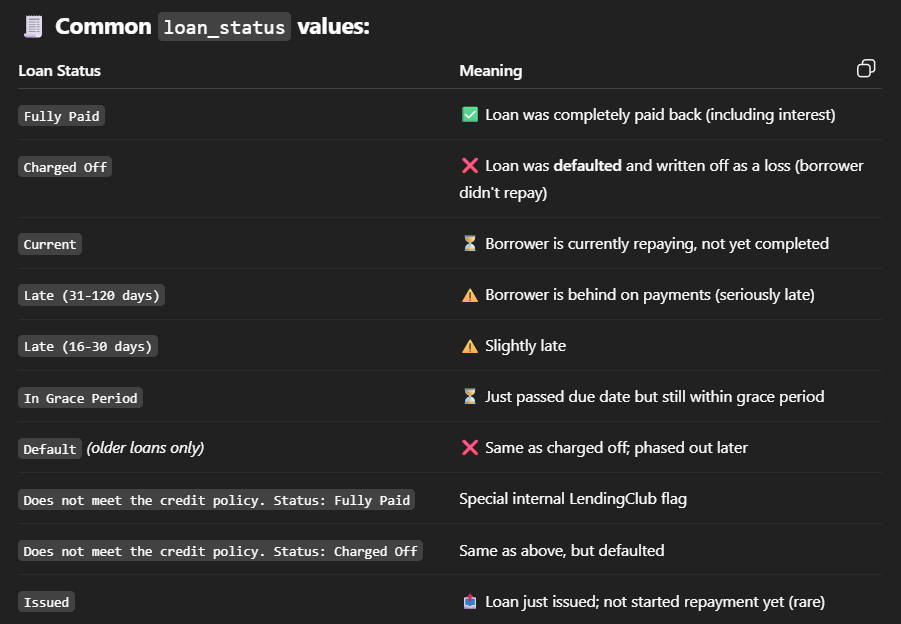

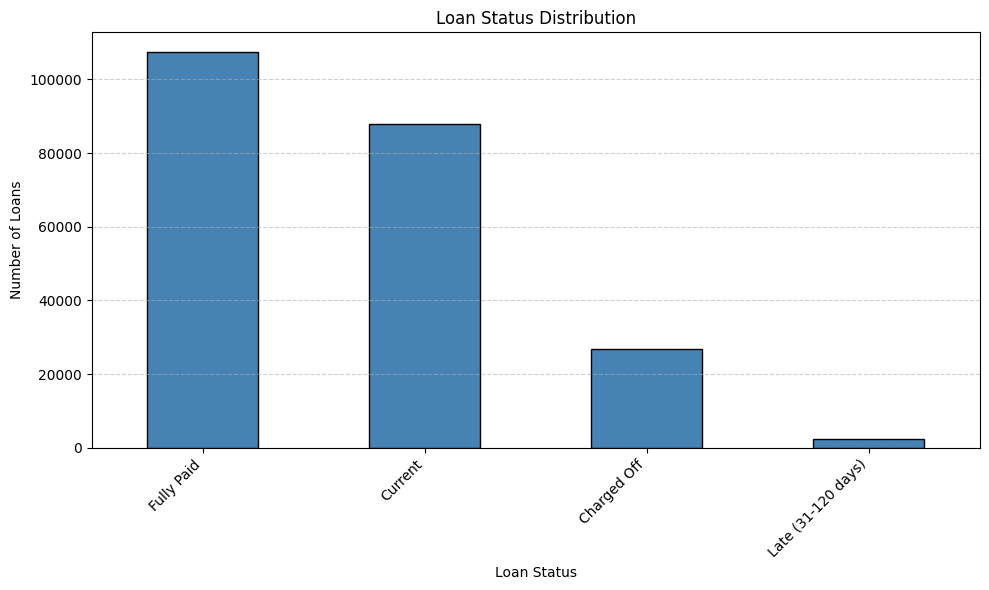

In [8]:
# ------------------------
# 2. Plot Loan Status Distribution (top 4)
# ------------------------
plt.figure(figsize=(10,6))
df['loan_status'].value_counts()[:4].plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Loan Status Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Number of Loans")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##### From Here On, Focus Only On Loans With Final Outcomes: `Fully Paid` and `Charged Off`

In [9]:
# ------------------------
# 3. Filter Only 'Fully Paid' and 'Charged Off'
# ------------------------
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Add target column
df['default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df.drop(columns=['loan_status'], inplace=True)


##### Select Safe, Interpretable Features (no leakage!)

In [ ]:
safe_features = [
    'loan_amnt',          # Requested loan size
    'term',               # 36/60 months
    'grade',              # LendingClub's internal grade (A-G)
    'emp_length',         # Employment duration
    'home_ownership',     # Rent/Own/Mortgage
    'annual_inc',         # Income
    'purpose',            # Loan purpose
    'dti',                # Debt-to-income ratio
    'fico_range_high',    # Credit score
    'open_acc',           # Open credit lines
    'revol_bal',          # Revolving balance
    'revol_util',         # Utilization rate
    'total_acc'           # Total credit accounts
]

df = df[safe_features + ['default']]

##### Preprocessing (NaNs + Label Encoding)

In [12]:
from sklearn.preprocessing import LabelEncoder
# Fill missing numeric values with median
df = df.fillna(df.median(numeric_only=True))

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='default')
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

c:\Users\athar\Anaconda3\envs\py312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"📈 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89     21465
           1       0.51      0.11      0.18      5396

    accuracy                           0.80     26861
   macro avg       0.66      0.54      0.53     26861
weighted avg       0.75      0.80      0.74     26861

📈 ROC AUC Score: 0.7117
🧾 Confusion Matrix:
[[20917   548]
 [ 4817   579]]


##### We'll have to make the classes balanced, since the model cannot catch defaulters
🔍 What This Means
Good at catching non-defaulters (class 0): 97% recall for non-defaults is solid

Struggles with catching defaulters (class 1): Only 11% recall for defaults — it's missing most of them
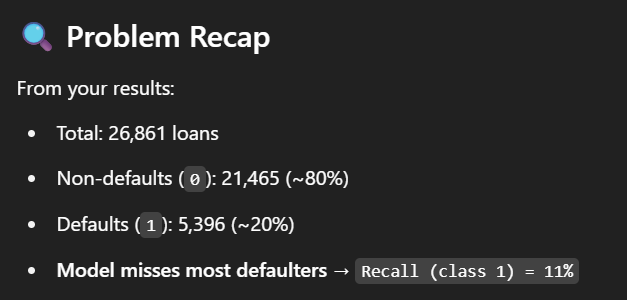
<br>
<br>

##### We will use XGBoost's inbuilt `scale_pos_weight` which is the built-in support for imbalance.

In [19]:
# Compute ratio of class 0 to class 1
scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale,
    random_state=42
)

model.fit(X_train, y_train)

c:\Users\athar\Anaconda3\envs\py312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:22:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"📈 ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77     21465
           1       0.33      0.62      0.43      5396

    accuracy                           0.67     26861
   macro avg       0.60      0.65      0.60     26861
weighted avg       0.77      0.67      0.70     26861

📈 ROC AUC Score: 0.7082
🧾 Confusion Matrix:
[[14636  6829]
 [ 2050  3346]]


🎯 That 62% recall on defaults means:
You're now catching most of the people who default, even if precision dropped — which is fine in finance!

It’s often better to flag a few good borrowers than to miss defaulters who cost real money.

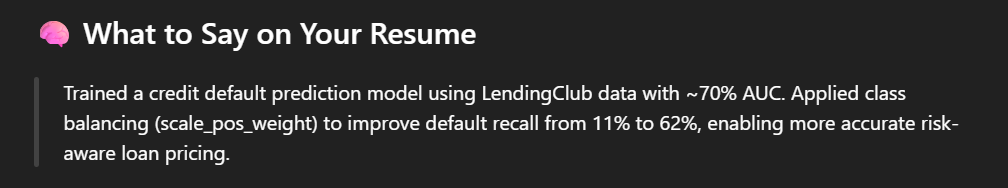

### Now we have got PD (Probability of Default) for each loan, we can use it to make decisions about lending (thus interest  rates!)

Our objective is to maximize profit, given the risk of default. (PD)

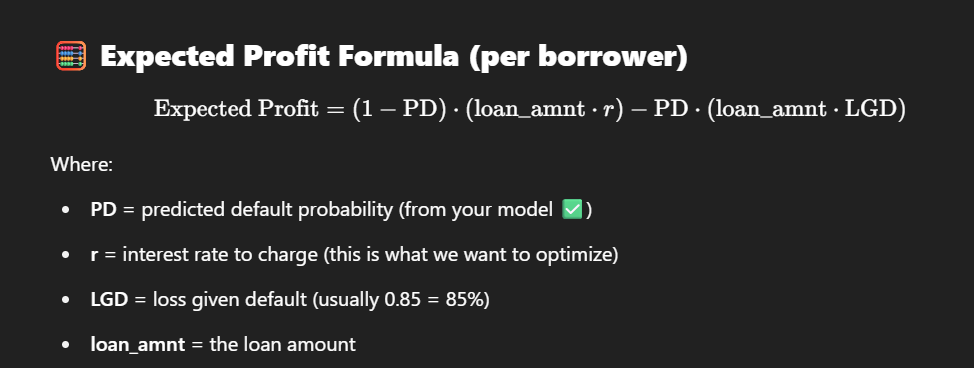

Let’s Do This for One Borrower (Example)

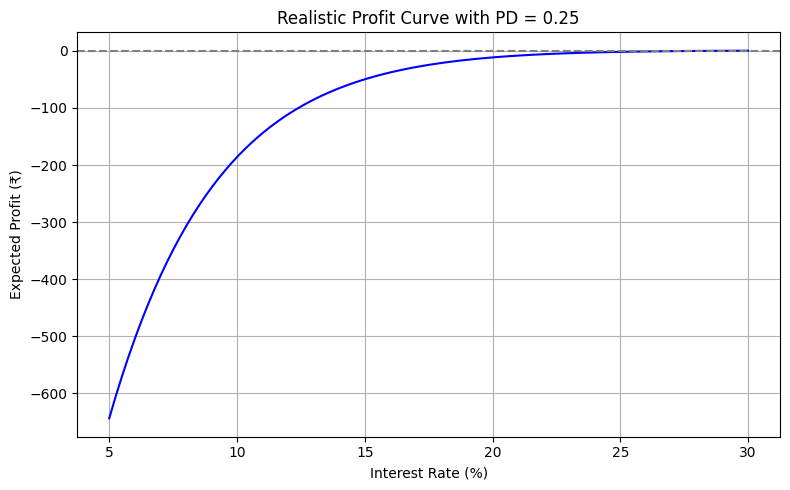

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Borrower data
PD = 0.25
loan_amnt = 10000
LGD = 0.85
k = 20  # Controls how sharply take rate drops with r

# Try rates from 5% to 30%
rates = np.linspace(0.05, 0.30, 100)
profits = []

for r in rates:
    income = loan_amnt * r
    loss = loan_amnt * LGD
    base_profit = (1 - PD) * income - PD * loss
    
    # Borrower's probability of accepting the loan
    take_rate = np.exp(-k * r)  # Exponentially decaying take rate
    expected_profit = take_rate * base_profit
    profits.append(expected_profit)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(rates * 100, profits, color='blue')
plt.xlabel("Interest Rate (%)")
plt.ylabel("Expected Profit (₹)")
plt.title(f"Realistic Profit Curve with PD = {PD}")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()